In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import time_evolutor as te
import plotting as p

import sys
sys.path.append('/../../temp_prog/')
import tur_calculator as tc

In [2]:
#------------------SETUP-------------------

T_L = 25 
T_R = 10
V_B = 30
eps = 50
u = 250
gamma = 1
delta_gamma = 0.04 #0.04
delta_epsilon = 0.04 #0.04

INPUT = {
    'eps': eps,
    'omega': 0, 
    'u': u, 
    'V_B': V_B,
    'gamma': gamma,  
    'T_L': T_L,
    'T_R': T_R,
    'delta_gamma': delta_gamma,
    'delta_epsilon': delta_epsilon,
}

initial = [1/4,1/4,1/4,1/4,0,0]         #beginns with both QDs empty
ti_array = np.linspace(0,1e5,10000)

In [3]:
importlib.reload(te)
sys, liouvillian, dim, eval_j, left_ev, right_ev, nleads = te.calculate_paper_meta(initial, ti_array, **INPUT, just_lio=True)

[[ 1.  0.  0. -0.  0.  0.]
 [-0.  1.  0. -0. -0.  0.]
 [ 0.  0.  1.  0. -0. -0.]
 [-0. -0. -0.  1.  0.  0.]
 [ 0. -0.  0.  0.  1.  0.]
 [ 0.  0. -0. -0.  0.  1.]]
check l1 is identity: [-0.5 -0.5 -0.5 -0.5 -0.   0. ]


In [4]:
#Theoretically calculating my_rho

muL = -V_B/2
muR = V_B/2

def fermi(mu, E, T):
    return 1/(1+np.exp((E-mu)/T))

def avg_fermi(eps):
    return (fermi(muL, eps, T_L)+fermi(muR, eps, T_R))/2

avg_fermi_e = avg_fermi(eps)
avg_fermi_eU = avg_fermi(eps+u)

my_rho1 = np.zeros(dim)
my_rho2 = np.zeros(dim)

#filling up my_rho1:
my_rho1[0] = 1-avg_fermi_e
my_rho1[1] = avg_fermi_e/2
my_rho1[2] = avg_fermi_e/2
my_rho1[4] = avg_fermi_e/2

#filling up my_rho2:
my_rho2[1] = (1-avg_fermi_eU)/2
my_rho2[2] = (1-avg_fermi_eU)/2
my_rho2[3] = avg_fermi_eU
my_rho2[4] = -(1-avg_fermi_eU)/2

In [5]:
print(my_rho1)
print(my_rho2)

[0.95077467 0.02461266 0.02461266 0.         0.02461266 0.        ]
[ 0.00000000e+00  4.99999157e-01  4.99999157e-01  1.68600214e-06
 -4.99999157e-01  0.00000000e+00]


In [6]:
# -----------------------------PARTICLE CURRENT-------------------------------------
# qmeq solution for stationary current (at left lead)
I_ss = sys.current[0]
print('I_ss: ', I_ss)
print('right lead? ', sys.current[1])

# reset current    
sys.current[:] = np.zeros(nleads)
sys.energy_current[:] = np.zeros(nleads)

# set stationary state to my_rho value
sys.phi0[:] = np.real(my_rho1[:])

# calculate current (also calculates energy and heat currents)
sys.appr.generate_current() # calculates current both ways
J_QH_tot = sys.heat_current
I_test = sys.current[0]
print(I_test)
I = sys.current_noise[0] 
I_var = sys.current_noise[1]
#--------------------------------------------
# take QmeQ heat current at left lead   
J_QH = J_QH_tot[0]
print('J_QH: ', J_QH)

#Power
P = I*V_B

I_ss:  0.03787769438531496
right lead?  -0.03787769438531495
0.03985496910444492
J_QH:  2.590702024811203


In [7]:
#Calculate TUR
importlib.reload(tc)
TUR, eff_carnot, eff, sigma = tc.calculate_single_tur(T_L, T_R, I, I_var, J_QH, P)

In [8]:
print('I', I)
print('P', P)
print('I_var', I_var)
print('heat current: ', J_QH)
print('sigma: ', sigma)
print('eff: ', eff)
print('TUR', TUR)

I 0.039854969104444936
P 1.195649073133348
I_var 0.09069103168131445
heat current:  2.590702024811203
sigma:  0.03587721417533739
eff:  0.4615154740616998
TUR 2.0484157290809812


In [9]:
i_1 = gamma*(fermi(muL, eps, T_L)-fermi(muR, eps, T_R))
i_2 = gamma*(fermi(muL, eps+u, T_L)-fermi(muR, eps+u, T_R))

print(i_1, i_2)

0.039826189591990496 3.372003444311221e-06


In [10]:
importlib.reload(te)
rho_ss, rho_t = te.time_evolution(left_ev, right_ev, eval_j, my_rho1, liouvillian, ti_array, dim)

49.96 50.04


c:\temp_prog\venv\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\temp_prog\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


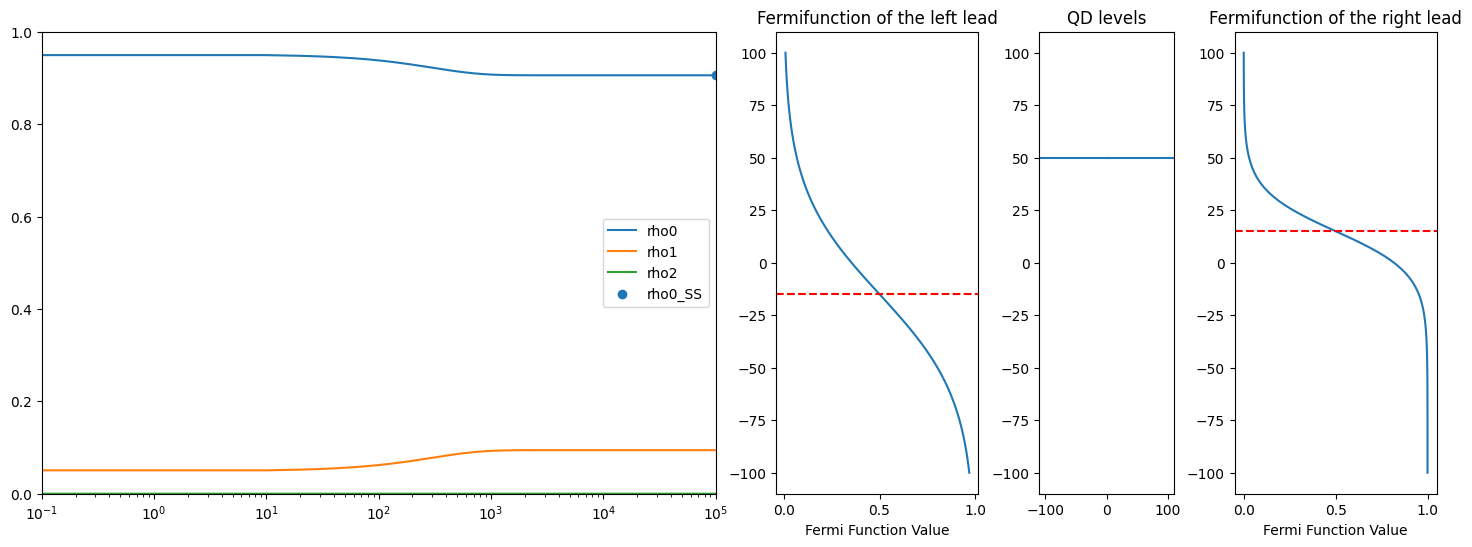

In [11]:
epsilons = np.linspace(-100,100,100)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'width_ratios': [10, 3, 2, 3]}) 

importlib.reload(p)
rho_0 = rho_t[0]
rho_1 = rho_t[1]+rho_t[2]
rho_2 = rho_t[3]

ax1.plot(ti_array, rho_0, label='rho0')
ax1.plot(ti_array, rho_1, label='rho1')
ax1.plot(ti_array, rho_2, label='rho2')
ax1.scatter(ti_array[-1], rho_ss[0], label='rho0_SS')
ax1.set_xscale('log')
ax1.set_xlim(1e-1,1e5)
ax1.set_ylim(0, 1)
ax1.legend()

eps1 = eps-delta_epsilon
eps2 =eps+delta_epsilon
print(eps1, eps2)

importlib.reload(p)
p.plot_fermi_function(epsilons, muL, T_L, ax2, "Fermifunction of the left lead")
p.plot_double_qd_leves(epsilons, eps1, eps2, ax3, 'QD levels')
p.plot_fermi_function(epsilons, muR, T_R, ax4, "Fermifunction of the right lead")

plt.show()

In [12]:
# -----------------------------PARTICLE CURRENT-------------------------------------

J_QH_tot = np.zeros((nleads,ti_array.shape[0]))
I = np.zeros((ti_array.shape[0]))
I_var = np.zeros((ti_array.shape[0]))


for i in range(ti_array.shape[0]):
    
    # reset current    
    sys.current[:] = np.zeros(nleads)
    sys.energy_current[:] = np.zeros(nleads)
    
    
    # set stationary state to rho_t value
    sys.phi0[:] = np.real(rho_t[:,i])
    
    # calculate current (also calculates energy and heat currents)
    sys.appr.generate_current() # calculates current both ways
    J_QH_tot[:,i] = sys.heat_current
    I[i] = sys.current_noise[0] 
    I_var[i] = sys.current_noise[1]
    
    #--------------------------------------------

# take QmeQ heat current at left lead   
J_QH = J_QH_tot[0]
print('J_QH: ', J_QH)

#Power
P = I*V_B

J_QH:  [2.59070202 2.58550485 2.58141986 ... 2.46209081 2.46209081 2.46209081]


In [13]:
importlib.reload(tc)
TUR, eff_carnot, eff, sigma = tc.calculate_tur(T_L, T_R, I, I_var, J_QH, P)

In [30]:
print(type(TUR))

<class 'numpy.ndarray'>


0.46151547406169996 0.4615308375505899


Text(0.5, 1.0, 'TUR factor')

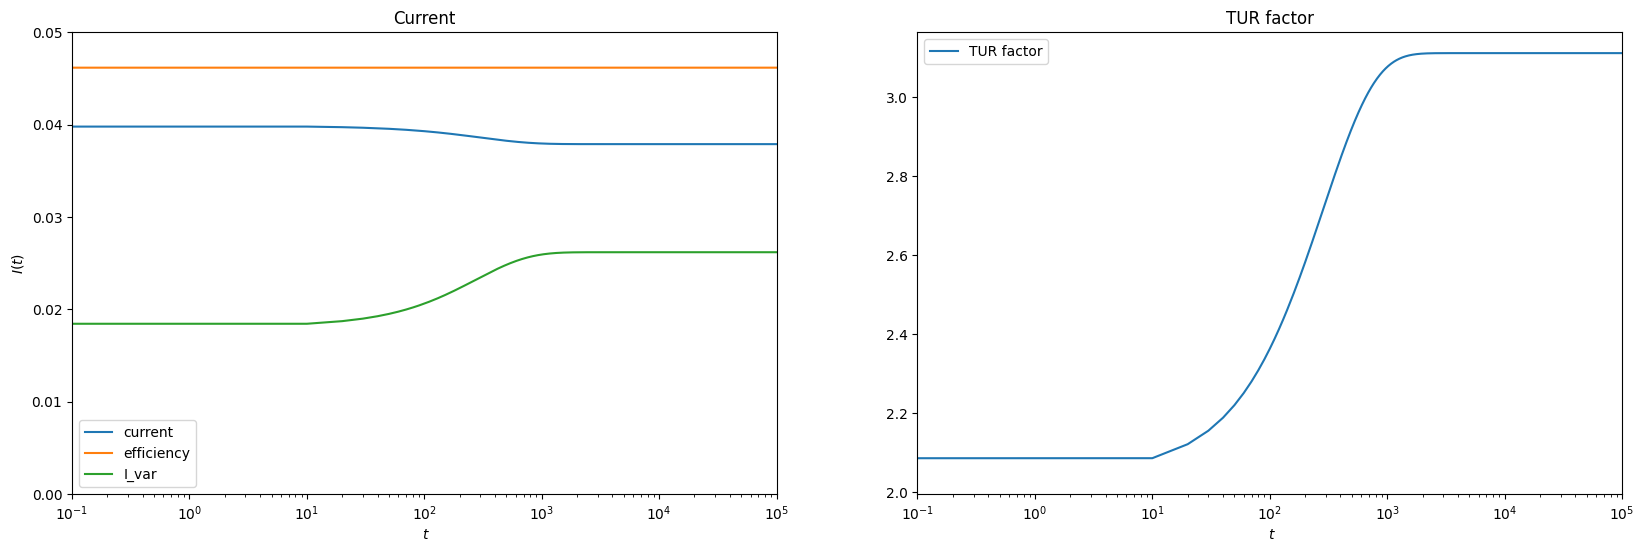

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ax1.plot(ti_array,I, label = 'current')
ax1.plot(ti_array, 0.1*eff, label='efficiency')
ax1.plot(ti_array, 0.2*I_var, label='I_var')

ax1.legend()

ax1.set_xlabel(r' $t$')
ax1.set_ylabel(r'$I(t)$')
ax1.set_xscale('log')
ax1.set_xlim(1e-1,1e5)
ax1.set_ylim(0, 0.05)
ax1.set_title('Current')

ax2.plot(ti_array,TUR, label = 'TUR factor')
print(np.min(eff), np.max(eff))

ax2.legend()

ax2.set_xlabel(r' $t$')
#ax2.set_ylabel('TUR-factor')
ax2.set_xscale('log')
ax2.set_xlim(1e-1,1e5)
ax2.set_title('TUR factor')